# 🏡 Finding Drivers of Zestimate Errors - Modeling Notebook
---

This notebook serves as a guide to the data science process following exploration through model testing. This is the sibling notebook to `exploration.ipynb` which contains the process from acquisition through exploration. This may serve as additional resource for insights found in the `final_report.ipynb` or as a guide for project reproduction.

**⏯ Initialize Notebook**

In [1]:
# import standard libraries
import pandas as pd
import numpy as np

# import created scripts
import explore
import model
from wrangle import wrangle_zillow

# import model tools
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

# cosmetic imports and settings
import warnings
warnings.filterwarnings("ignore")
from matplotlib.pyplot import style
style.use('~/.matplotlib/gruvbox.mplstyle')
from end import end

In [2]:
X_train, y_train,\
X_validate, y_validate, \
X_test, y_test = wrangle_zillow()


*----------------------------------------*
|  ***   Data Preparation Summary   ***  |
*----------------------------------------*
|                                        |
|       Initial Observations: 77,579     |
|      Prepared Observations: 61,625     |
|          Null Loss Percent: 20.56%     |
|                                        |
|       X_train Observations: 36,975     |
|           Percent of Total: 48%        |
|               Percent of X: 60%        |
|                                        |
|    X_validate Observations: 12,325     |
|           Percent of Total: 16%        |
|               Percent of X: 20%        |
|                                        |
|        X_test Observations: 12,325     |
|           Percent of Total: 16%        |
|               Percent of X: 20%        |
|                                        |
*~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~*


## 🔹 Modeling and Evaluation
---

### Scale Data for Modeling

The initial step before running the data through models is to appropriately scale the data. Using the `sklearn` `StandardScaler` object, the scaler will be fit to the data train, and the columns to be scaled will be transformed and stored into `_scaled` variables on their respective DataFrames.

In [3]:
# set list of columns to be scaled and non-scaled
cols_to_scale = [
    'acreage',
    'age',
    'bathrooms',
    'bedrooms',
    'bedrooms_per_sqft',
    'full_bathrooms',
    'land_value_usd',
    'latitude',
    'longitude',
    'property_value_usd',
    'room_count',
    'structure_square_feet',
    'structure_value_usd',
    'tax_amount_usd']
unscaled_cols = [
    'bed_sqft_age_clstr_1',
    'bed_sqft_age_clstr_2',
    'bed_sqft_age_clstr_3',
    'bed_sqft_age_clstr_4',
    'census_tractcode',
    'la_county',
    'lat_long_clstr_1',
    'lat_long_clstr_2',
    'lat_long_clstr_3',
    'lat_long_clstr_4',
    'lot_rooms_clstr_1',
    'lot_rooms_clstr_2',
    'lot_rooms_clstr_3',
    'lot_rooms_clstr_4',
    'orange_county',
    'tract_size_age_clstr_1',
    'tract_size_age_clstr_2',
    'tract_size_age_clstr_3',
    'tract_size_age_clstr_4',
    'ventura_county']

In [4]:
for col in cols_to_scale:
    # create scaler object
    scaler = StandardScaler()
    # fit scaler object to train and transform
    X_train[f'{col}_scaled'] = scaler.fit_transform(X_train[[col]])
    # transform validate and test with train fit scaler
    X_validate[f'{col}_scaled'] = scaler.transform(X_validate[[col]])
    X_test[f'{col}_scaled'] = scaler.transform(X_test[[col]])

### Setting Features

Three sets of features will be used in modeling. One set each will be created using `rfe` and `SelectKBest` for the top 9 recommended. Lastly, a feature set using the seemingly strongest cluster group along with location related features will be created. All three will be tested using four different modeling algorithms.

In [5]:
# create list to hold all feature names
all_features = X_train.filter(regex='scaled').columns.to_list() + unscaled_cols

In [6]:
# use RFE to find top 9 recommended features for modeling
top_n = explore.select_rfe(X_train[all_features], y_train.log_error, n=9)
print(f'\nThe top recommended features via RFE are:\n{top_n}.\n')


The top recommended features via RFE are:
['structure_value_usd_scaled', 'bed_sqft_age_clstr_2', 'bed_sqft_age_clstr_4', 'lat_long_clstr_2', 'lot_rooms_clstr_1', 'lot_rooms_clstr_2', 'lot_rooms_clstr_3', 'tract_size_age_clstr_2', 'tract_size_age_clstr_3'].



In [7]:
# use RFE to find top 9 recommended features for modeling
top_k = explore.select_kbest(X_train[all_features], y_train.log_error, k=9)
print(f'\nThe top recommended features via SelectKBest are:\n{top_k}.\n')


The top recommended features via SelectKBest are:
['bathrooms_scaled', 'bedrooms_scaled', 'full_bathrooms_scaled', 'room_count_scaled', 'structure_square_feet_scaled', 'lat_long_clstr_1', 'lot_rooms_clstr_1', 'tract_size_age_clstr_1', 'tract_size_age_clstr_2'].



In [8]:
# set features for strongest cluster, location, and lot size
in_features = [
    'acreage_scaled',
    'census_tractcode',
    'lot_rooms_clstr_1',
    'lot_rooms_clstr_2',
    'lot_rooms_clstr_3',
    'lot_rooms_clstr_4',
    'la_county',
    'orange_county']

### Setting Baselines
Two baselines will be created as additional comparison metrics. `baseline_mean` will be created using the mean of `log_error` of the `y_train`, and `baseline_median` will be created using the median `log_error` of the `y_train`. These baselines will be used to measure performance against both out-of-sample evaluation on the `validate` data set and the `test` data set.

In [9]:
# create variable holding mean of log_error and attach to y
baseline_mean = y_train.log_error.mean()
y_train['baseline_mean'] = baseline_mean
y_validate['baseline_mean'] = baseline_mean
y_test['baseline_mean'] = baseline_mean

In [10]:
# create variable holding mean of log_error and attach to y
baseline_median = y_train.log_error.median()
y_train['baseline_median'] = baseline_median
y_validate['baseline_median'] = baseline_median
y_test['baseline_median'] = baseline_median

***Train***

Create DataFrames to hold mean and median baselines for future comparison on `train` performance.

In [11]:
# obtain mean baseline performance for model comparison on in-sample
rmse, r2 = model.get_metrics(y_train.log_error, y_train.baseline_mean)
model_dict = {'model':'baseline_mean', 'RMSE':rmse, 'R^2':r2}
insamp_df = pd.DataFrame([model_dict])

In [12]:
# obtain median baseline performance for model comparison on in-sample
rmse, r2 = model.get_metrics(y_train.log_error, y_train.baseline_median)
model_dict = {'model':'baseline_median', 'RMSE':rmse, 'R^2':r2}
insamp_df = insamp_df.append([model_dict], ignore_index=True)

***Validate***

Create DataFrames to hold mean and median baselines for future comparison on `validate` performance.

In [13]:
# obtain mean baseline performance for model comparison on out-of-sample
rmse, r2 = model.get_metrics(y_validate.log_error, y_validate.baseline_mean)
model_dict = {'model':'baseline_mean', 'RMSE':rmse, 'R^2':r2}
outsamp_df = pd.DataFrame([model_dict])

In [14]:
# obtain median baseline performance for model comparison on out-of-sample
rmse, r2 = model.get_metrics(y_validate.log_error, y_validate.baseline_median)
model_dict = {'model':'baseline_median', 'RMSE':rmse, 'R^2':r2}
outsamp_df = outsamp_df.append([model_dict], ignore_index=True)

***Test***

Create DataFrames to hold mean and median baselines for future comparison on `test` performance.

In [15]:
# obtain mean baseline performance for model comparison on test
rmse, r2 = model.get_metrics(y_test.log_error, y_test.baseline_mean)
model_dict = {'model':'baseline_mean', 'RMSE':rmse, 'R^2':r2}
test_df = pd.DataFrame([model_dict])

In [16]:
# obtain median baseline performance for model comparison on test
rmse, r2 = model.get_metrics(y_test.log_error, y_test.baseline_median)
model_dict = {'model':'baseline_median', 'RMSE':rmse, 'R^2':r2}
test_df = test_df.append([model_dict], ignore_index=True)

### Ordinary Least Squares

#### ⚙️ 1

In [17]:
# using top five according to RFE on train

# create model object
lm1 = LinearRegression(normalize=True)
# run train_model function to fit model to train and obtain performance metrics
y_train['lm1_predictions'], model_dict = model.train_model(X_train[top_n], y_train.log_error, lm1, 'lm1')
# append performance metrics to dataframe
insamp_df = insamp_df.append([model_dict], ignore_index=True)

In [18]:
# show current model performance on train
pd.DataFrame([model_dict])

,model,RMSE,R^2
0,lm1,0.156488,0.002863


In [19]:
# run model_testing function to evaluate performance using out-of-sample data set
y_validate['lm1_predictions'], model_dict = model.model_testing(X_validate[top_n], y_validate.log_error, lm1, 'lm1')
# append performance metrics to dataframe
outsamp_df = outsamp_df.append([model_dict], ignore_index=True)

#### ⚙️ 2

In [20]:
# using top five according to SelectKBest on train

# create model object
lm2 = LinearRegression(normalize=True)
# run train_model function to fit model to train and obtain performance metrics
y_train['lm2_predictions'], model_dict = model.train_model(X_train[top_k], y_train.log_error, lm2, 'lm2')
# append performance metrics to dataframe
insamp_df = insamp_df.append([model_dict], ignore_index=True)

In [21]:
# show current model performance on train
pd.DataFrame([model_dict])

,model,RMSE,R^2
0,lm2,0.156606,0.001362


In [22]:
# run model_testing function to evaluate performance using out-of-sample data set
y_validate['lm2_predictions'], model_dict = model.model_testing(X_validate[top_k], y_validate.log_error, lm2, 'lm2 ')
# append performance metrics to dataframe
outsamp_df = outsamp_df.append([model_dict], ignore_index=True)

#### ⚙️ 3

In [23]:
# using manually chosen features on train

# create model object
lm3 = LinearRegression(normalize=True)
# run train_model function to fit model to train and obtain performance metrics
y_train['lm3_predictions'], model_dict = model.train_model(X_train[in_features], y_train.log_error, lm3, 'lm3')
# append performance metrics to dataframe
insamp_df = insamp_df.append([model_dict], ignore_index=True)

In [24]:
# show current model performance on train
pd.DataFrame([model_dict])

,model,RMSE,R^2
0,lm3,0.156586,0.001609


In [25]:
# run model_testing function to evaluate performance using out-of-sample data set
y_validate['lm3_predictions'], model_dict = model.model_testing(X_validate[in_features], y_validate.log_error, lm3, 'lm3')
# append performance metrics to dataframe
outsamp_df = outsamp_df.append([model_dict], ignore_index=True)

#### 🔥 Results

In [26]:
# pull DataFrame with Baseline and specific models for comparison
insamp_df[insamp_df.model.str.contains('base') | insamp_df.model.str.contains('lm')].sort_values('RMSE')

,model,RMSE,R^2
2,lm1,0.156488,0.002863
4,lm3,0.156586,0.001609
3,lm2,0.156606,0.001362
0,baseline_mean,0.156712,0.000000
1,baseline_median,0.157023,0.000000


- All models beat both baselines predicting in-sample data
- `lm1`, using top 9 `rfe` selected features, was the best performer
- `lm3`, using manually selected features, was the lowest performer

### Polynomial Regression

#### ⚙️ 1

In [27]:
# create polynomial object
pf1 = PolynomialFeatures()
# fit to and transform train
X_train_deg2 = pf1.fit_transform(X_train[top_n])
# transform validate
X_validate_deg2 = pf1.transform(X_validate[top_n])

In [28]:
# using top five according to RFE on train

# create model object
pl1 = LinearRegression(normalize=True)
# run train_model function to fit model to train and obtain performance metrics
y_train['pl1_predictions'], model_dict = model.train_model(X_train_deg2, y_train.log_error, pl1, 'pl1')
# append performance metrics to dataframe
insamp_df = insamp_df.append([model_dict], ignore_index=True)

In [29]:
# show current model performance on train
pd.DataFrame([model_dict])

,model,RMSE,R^2
0,pl1,0.156298,0.005279


In [30]:
# run model_testing function to evaluate performance using out-of-sample data set
y_validate['pl1_predictions'], model_dict = model.model_testing(X_validate_deg2, y_validate.log_error, pl1, 'pl1')
# append performance metrics to dataframe
outsamp_df = outsamp_df.append([model_dict], ignore_index=True)

#### ⚙️ 2

In [31]:
# create polynomial object
pf2 = PolynomialFeatures()
# fit and transform to scaled train
X_train_deg2 = pf2.fit_transform(X_train[top_k])
# transform scaled validate
X_validate_deg2 = pf2.transform(X_validate[top_k])
# transform test
X_test_deg2 = pf2.transform(X_test[top_k])

In [32]:
# using top five according to SelectKBest on train

# create model object
pl2 = LinearRegression(normalize=True)
# run train_model function to fit model to train and obtain performance metrics
y_train['pl2_predictions'], model_dict = model.train_model(X_train_deg2, y_train.log_error, pl2, 'pl2')
# append performance metrics to dataframe
insamp_df = insamp_df.append([model_dict], ignore_index=True)

In [33]:
# show current model performance on train
pd.DataFrame([model_dict])

,model,RMSE,R^2
0,pl2,0.156482,0.002934


In [34]:
# run model_testing function to evaluate performance using out-of-sample data set
y_validate['pl2_predictions'], model_dict = model.model_testing(X_validate_deg2, y_validate.log_error, pl2, 'pl2')
# append performance metrics to dataframe
outsamp_df = outsamp_df.append([model_dict], ignore_index=True)

#### ⚙️ 3

In [35]:
# create polynomial object
pf3 = PolynomialFeatures()
# fit and transform to scaled train
X_train_deg2 = pf3.fit_transform(X_train[in_features])
# transform scaled validate
X_validate_deg2 = pf3.transform(X_validate[in_features])

In [36]:
# using manually chosen features on train

# create model object
pl3 = LinearRegression(normalize=True)
# run train_model function to fit model to train and obtain performance metrics
y_train['pl3_predictions'], model_dict = model.train_model(X_train_deg2, y_train.log_error, pl3, 'pl3')
# append performance metrics to dataframe
insamp_df = insamp_df.append([model_dict], ignore_index=True)

In [37]:
# show current model performance on train
pd.DataFrame([model_dict])

,model,RMSE,R^2
0,pl3,0.156491,0.002826


In [38]:
# run model_testing function to evaluate performance using out-of-sample data set
y_validate['pl3_predictions'], model_dict = model.model_testing(X_validate_deg2, y_validate.log_error, pl3, 'pl3')
# append performance metrics to dataframe
outsamp_df = outsamp_df.append([model_dict], ignore_index=True)

#### 🔥 Results

In [39]:
# pull DataFrame with Baseline and specific models for comparison
insamp_df[insamp_df.model.str.contains('base') | insamp_df.model.str.contains('pl')].sort_values('RMSE')

,model,RMSE,R^2
5,pl1,0.156298,0.005279
6,pl2,0.156482,0.002934
7,pl3,0.156491,0.002826
0,baseline_mean,0.156712,0.000000
1,baseline_median,0.157023,0.000000


- Two of three models beat both baselines predicting in-sample data, with `pl3` only beading median
- `pl1`, using top 9 `rfe` selected features, was the best performer
- `pl3`, using manually selected features, was the lowest performer

### LassoLars

#### ⚙️ 1

In [40]:
# using top five according to RFE on train

# create model object
lars1 = LassoLars()
# run train_model function to fit model to train and obtain performance metrics
y_train['lars1_predictions'], model_dict = model.train_model(X_train[top_n], y_train.log_error, lars1, 'lars1')
# append performance metrics to dataframe
insamp_df = insamp_df.append([model_dict], ignore_index=True)

In [41]:
# show current model performance on train
pd.DataFrame([model_dict])

,model,RMSE,R^2
0,lars1,0.156712,0.0


In [42]:
# run model_testing function to evaluate performance using out-of-sample data set
y_validate['lars1_predictions'], model_dict = model.model_testing(X_validate[top_n], y_validate.log_error, lars1, 'lars1')
# append performance metrics to dataframe
outsamp_df = outsamp_df.append([model_dict], ignore_index=True)

#### ⚙️ 2

In [43]:
# using top five according to SelectKBest on train

# create model object
lars2 = LassoLars()
# run train_model function to fit model to train and obtain performance metrics
y_train['lars2_predictions'], model_dict = model.train_model(X_train[top_k], y_train.log_error, lars2, 'lars2')
# append performance metrics to dataframe
insamp_df = insamp_df.append([model_dict], ignore_index=True)

In [44]:
# show current model performance on train
pd.DataFrame([model_dict])

,model,RMSE,R^2
0,lars2,0.156712,0.0


In [45]:
# run model_testing function to evaluate performance using out-of-sample data set
y_validate['lars2_predictions'], model_dict = model.model_testing(X_validate[top_k], y_validate.log_error, lars2, 'lars2')
# append performance metrics to dataframe
outsamp_df = outsamp_df.append([model_dict], ignore_index=True)

#### ⚙️ 3

In [46]:
# using manually chosen features on train

# create model object
lars3 = LassoLars()
# run train_model function to fit model to train and obtain performance metrics
y_train['lars3_predictions'], model_dict = model.train_model(X_train[in_features], y_train.log_error, lars3, 'lars3')
# append performance metrics to dataframe
insamp_df = insamp_df.append([model_dict], ignore_index=True)

In [47]:
# show current model performance on train
pd.DataFrame([model_dict])

,model,RMSE,R^2
0,lars3,0.156712,0.0


In [48]:
# run model_testing function to evaluate performance using out-of-sample data set
y_validate['lars3_predictions'], model_dict = model.model_testing(X_validate[in_features], y_validate.log_error, lars3, 'lars3')
# append performance metrics to dataframe
outsamp_df = outsamp_df.append([model_dict], ignore_index=True)

#### 🔥 Results

In [49]:
# pull DataFrame with Baseline and specific models for comparison
insamp_df[insamp_df.model.str.contains('base') | insamp_df.model.str.contains('lars')].sort_values('RMSE')

,model,RMSE,R^2
0,baseline_mean,0.156712,0.0
8,lars1,0.156712,0.0
9,lars2,0.156712,0.0
10,lars3,0.156712,0.0
1,baseline_median,0.157023,0.0


- All models failed to beat the mean baseline at predicting in-sample data

### TweedieRegressor

#### ⚙️ 1

In [50]:
# using top five according to RFE on train

# create model object
glm1 = TweedieRegressor()
# run train_model function to fit model to train and obtain performance metrics
y_train['glm1_predictions'], model_dict = model.train_model(X_train[top_n], y_train.log_error, glm1, 'glm1')
# append performance metrics to dataframe
insamp_df = insamp_df.append([model_dict], ignore_index=True)

In [51]:
# show current model performance on train
pd.DataFrame([model_dict])

,model,RMSE,R^2
0,glm1,0.156668,0.000566


In [52]:
# run model_testing function to evaluate performance using out-of-sample data set
y_validate['glm1_predictions'], model_dict = model.model_testing(X_validate[top_n], y_validate.log_error, glm1, 'glm1')
# append performance metrics to dataframe
outsamp_df = outsamp_df.append([model_dict], ignore_index=True)

#### ⚙️ 2

In [53]:
# using top five according to SelectKBest on train

# create model object
glm2 = TweedieRegressor()
# run train_model function to fit model to train and obtain performance metrics
y_train['glm2_predictions'], model_dict = model.train_model(X_train[top_k], y_train.log_error, glm2, 'glm2')
# append performance metrics to dataframe
insamp_df = insamp_df.append([model_dict], ignore_index=True)

In [54]:
# show current model performance on train
pd.DataFrame([model_dict])

,model,RMSE,R^2
0,glm2,0.156634,0.000995


In [55]:
# run model_testing function to evaluate performance using out-of-sample data set
y_validate['glm2_predictions'], model_dict = model.model_testing(X_validate[top_k], y_validate.log_error, glm2, 'glm2')
# append performance metrics to dataframe
outsamp_df = outsamp_df.append([model_dict], ignore_index=True)

#### ⚙️ 3

In [56]:
# using manually chosen features on train

# create model object
glm3 = TweedieRegressor()
# run train_model function to fit model to train and obtain performance metrics
y_train['glm3_predictions'], model_dict = model.train_model(X_train[in_features], y_train.log_error, glm3, 'glm3')
# append performance metrics to dataframe
insamp_df = insamp_df.append([model_dict], ignore_index=True)

In [57]:
# show current model performance on train
pd.DataFrame([model_dict])

,model,RMSE,R^2
0,glm3,0.156712,1.110223e-16


In [58]:
# run model_testing function to evaluate performance using out-of-sample data set
y_validate['glm3_predictions'], model_dict = model.model_testing(X_validate[in_features], y_validate.log_error, glm3, 'glm3')
# append performance metrics to dataframe
outsamp_df = outsamp_df.append([model_dict], ignore_index=True)

#### 🔥 Results

In [59]:
# pull DataFrame with Baseline and specific models for comparison
insamp_df[insamp_df.model.str.contains('base') | \
insamp_df.model.str.contains('glm')].sort_values('RMSE')

,model,RMSE,R^2
12,glm2,0.156634,9.953365e-04
11,glm1,0.156668,5.656474e-04
0,baseline_mean,0.156712,0.000000e+00
13,glm3,0.156712,1.110223e-16
1,baseline_median,0.157023,0.000000e+00


- All models beat both baselines at predictions on the in-sample data
- `glm2`, using top 5 SelectKBest features, was best performer
- `glm3`, using manually selected features, was worst at predictions

### Performance

Having seen the performance metrics of the twelve created models on in-sample data, here are the four best performers on the out-of-sample `validate` data set.

In [60]:
# output DataFrame with top four models according to RMSE
outsamp_df.sort_values('RMSE').head(4)

,model,RMSE,R^2
2,lm1,0.164097,0.000933
3,lm2,0.164126,0.000585
12,glm2,0.164140,0.000399
11,glm1,0.164147,0.000327


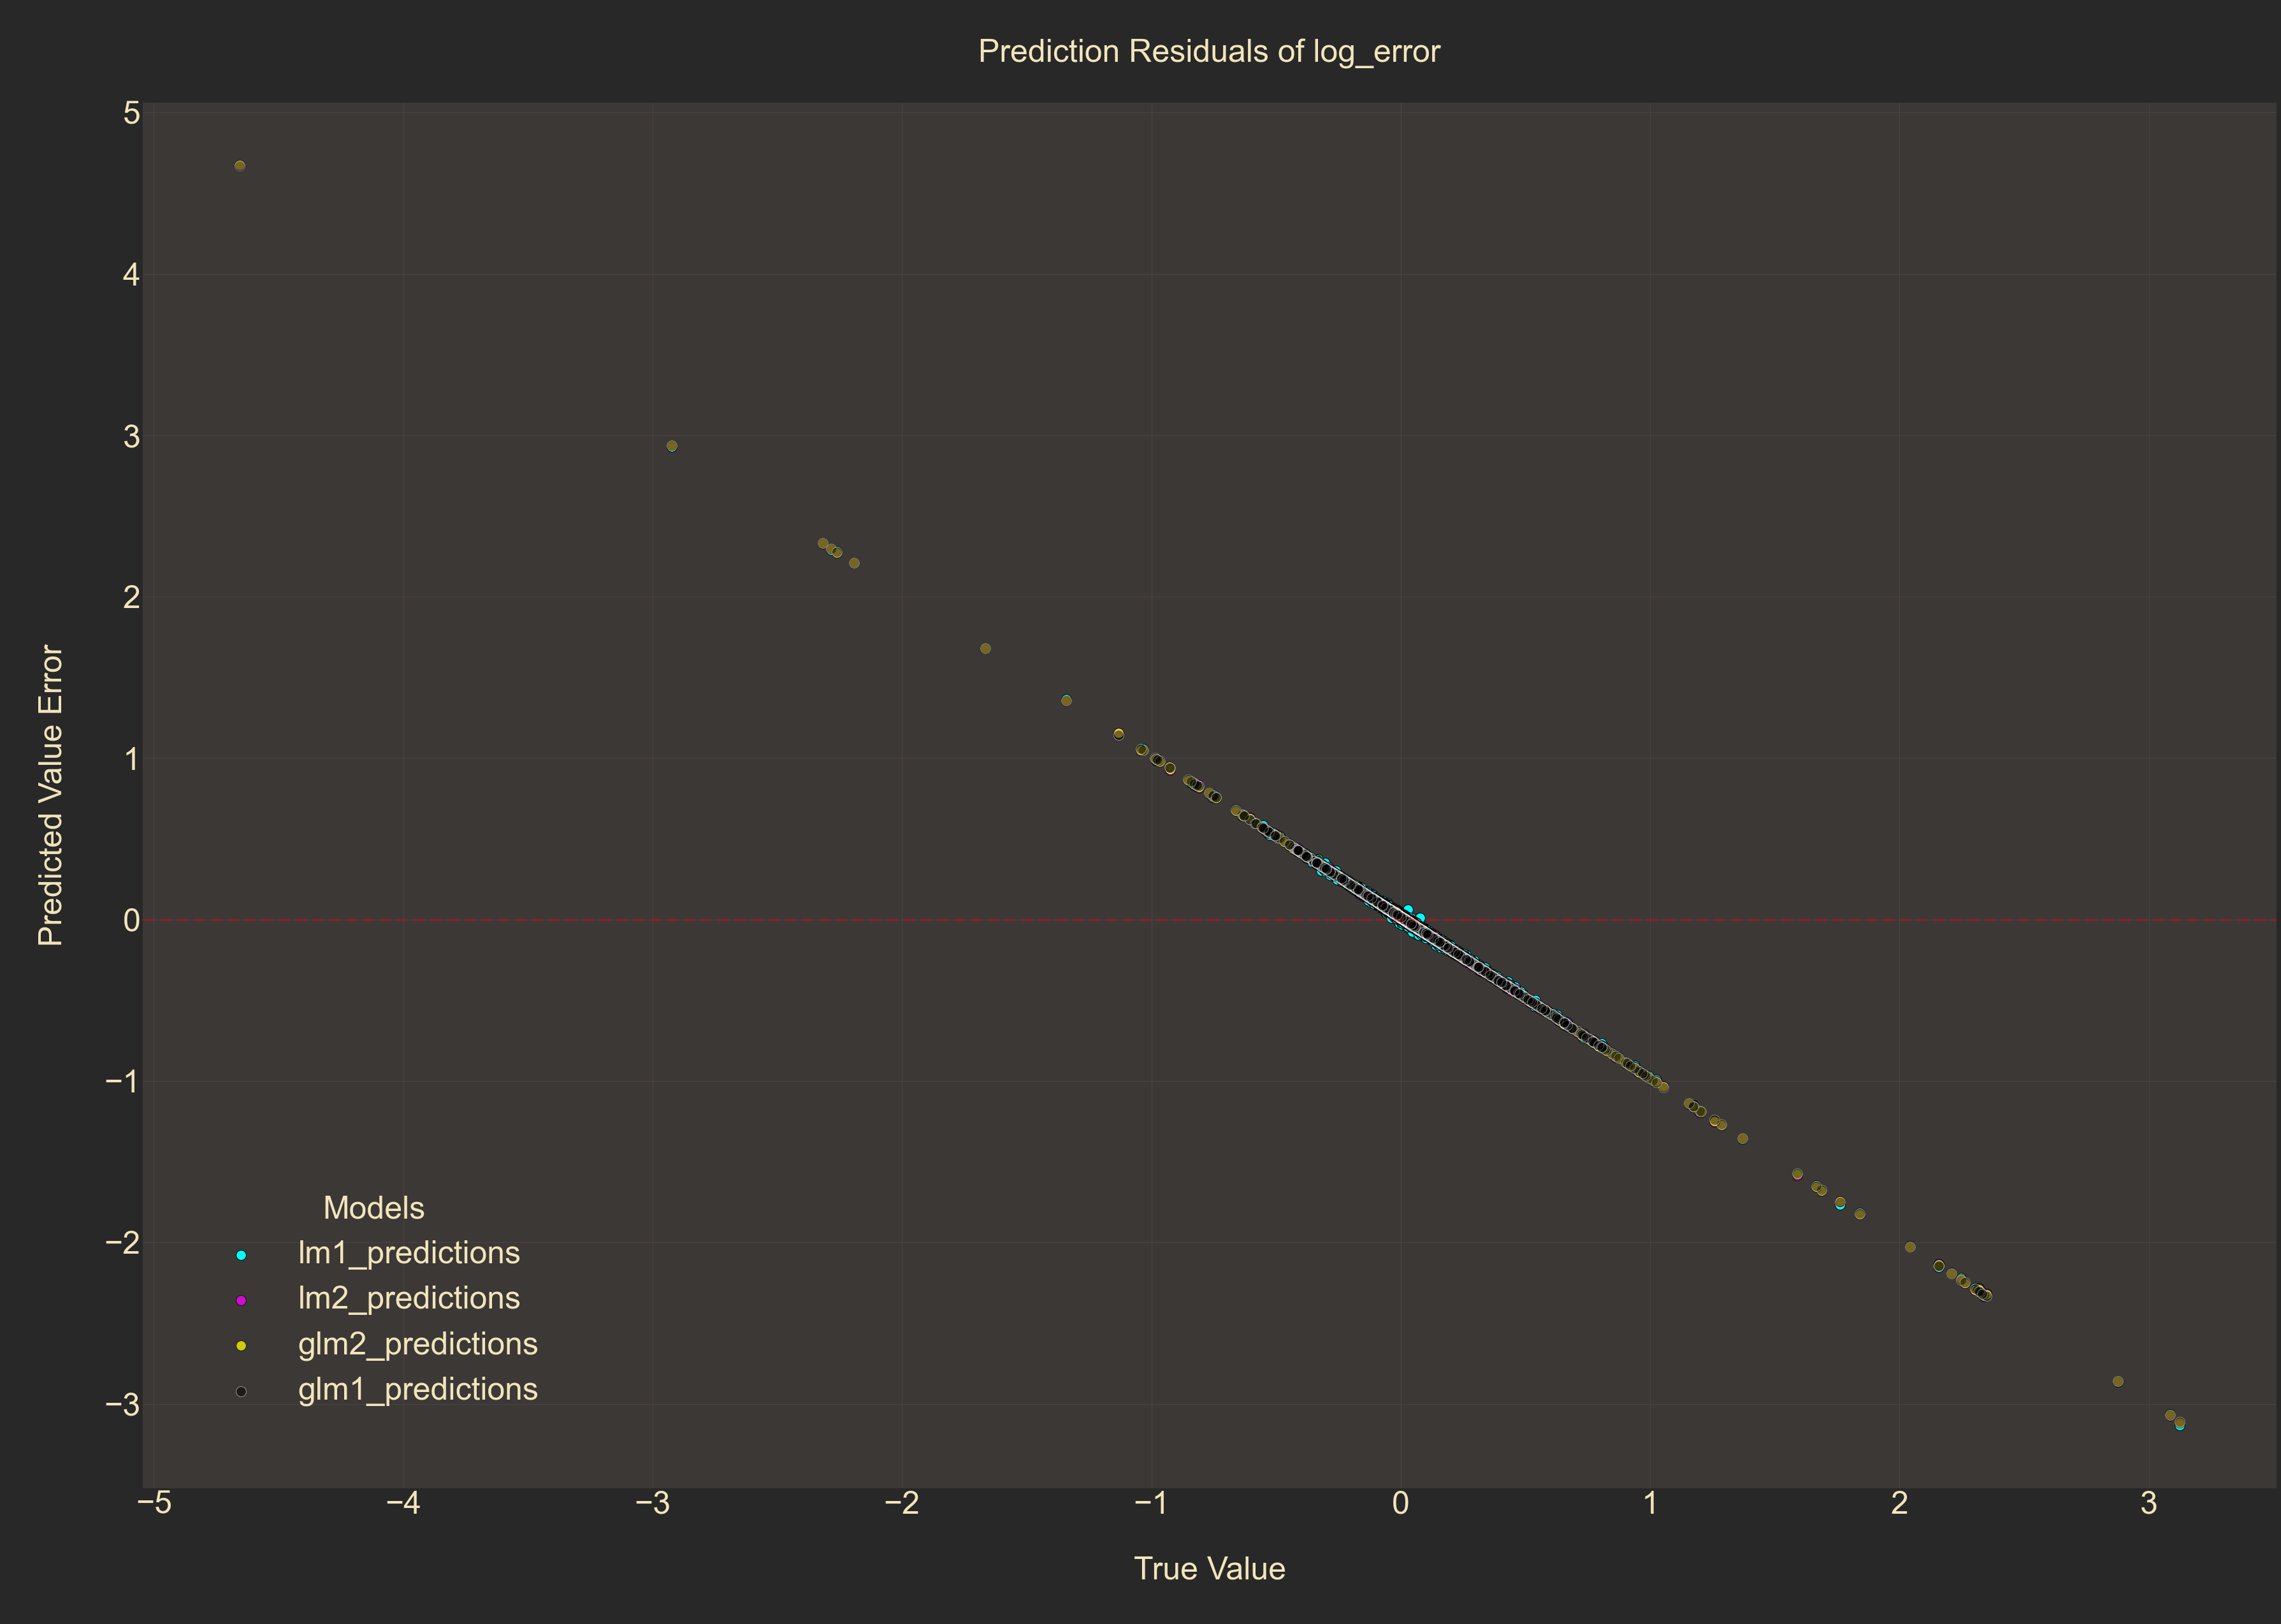

In [61]:
# plot residuals of top four models on out-of-sample validate
y_val_preds = y_validate[['lm1_predictions', 'lm2_predictions', 'glm2_predictions', 'glm1_predictions']]
y_val_true = y_validate.log_error
model.plot_residuals(y_val_true, y_val_preds)

- Residuals tended to be larger as the true value of `log_error` increased and decreased toward its extremes
- Model performance for the top four was consistent with performance on train, suggesting models were not overfit
- The best performing model `lm1`, while better than both baselines on `train` and `validate`, only performed $\approx0.05\%$ better than mean baseline on `validate`, hardly a worthwhile endeavor

## 🔹 Final Testing

The top performing model on the validate test will be used on the final $20\%$ `test` data set and measured against the baselines' RMSE.

In [62]:
# run model_testing function to evaluate performance using test data set
y_test['lm1_predictions'], model_dict = \
            model.model_testing(X_test[top_n], y_test.log_error, lm1, 'lm1')
# append performance metrics to dataframe
test_df = test_df.append([model_dict], ignore_index=True)

In [63]:
# compare baseline and model performance on test
test_df.sort_values('RMSE')

,model,RMSE,R^2
2,lm1,0.148260,0.00177
0,baseline_mean,0.148391,0.00000
1,baseline_median,0.148637,0.00000


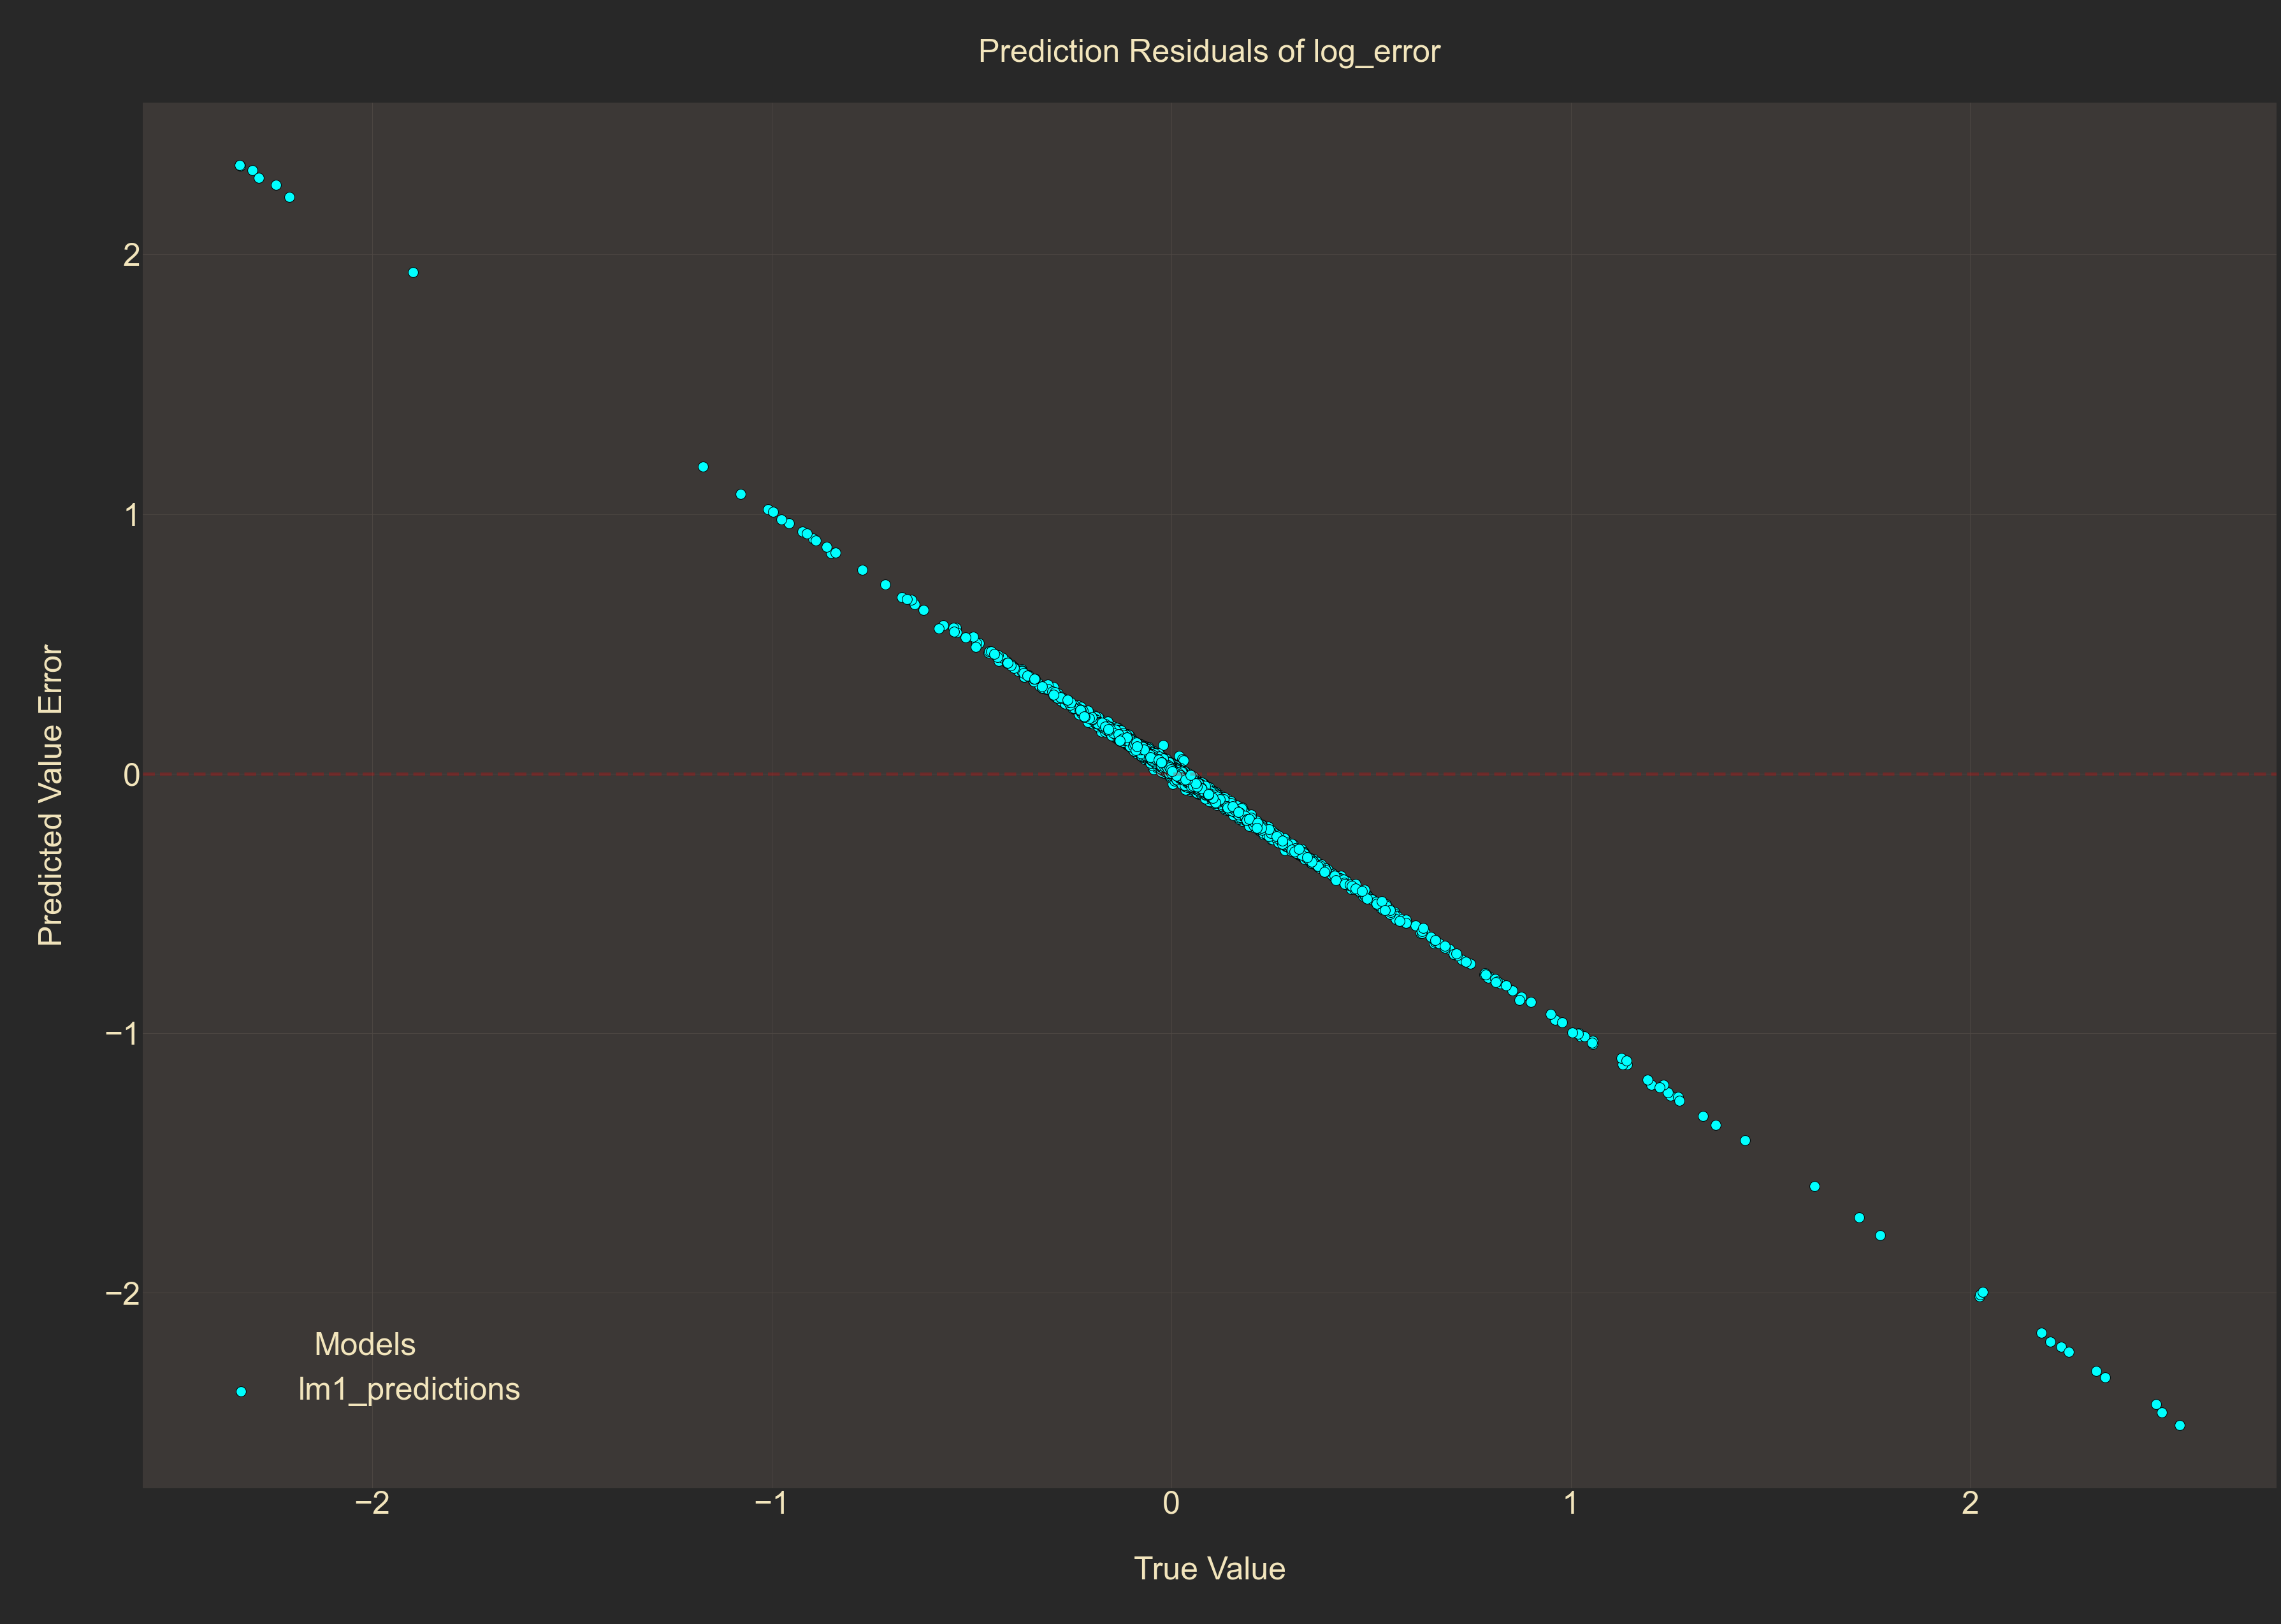

In [64]:
# plot residuals of model on test
model.plot_residuals(y_test.log_error, y_test[['lm1_predictions']])

## 🔹 Modeling Wrap-Up

The data that was prepared and explored in the `exploration.ipynb` notebook was used in the creation of twelve different models, using four different algorithms and three sets of features. First the data was scaled using the `sklearn` `StandardScaler`, and then two baselines were created using the mean and median of the `train` data set `log_error`. These baselines were used as comparison for relative performance for the models that were created. Finally, of the models created, the best performing one was put to predicting `log_error` of the `test` data set where it performed slightly above the baseline.

🔥 **Key Takeaways**

- Features selected with `rfe` and `SelectKBest` performed consistently better on all models and on in-sample and out-of-sample data
- `rfe` recommended cluster created features, while `SelectKBest` recommended only features found within the initial data
- All models had consistent performance across data sets, suggesting over fitting did not occur on the training
- Mean Baseline RMSE was $0.148391$ on `test`
- `LinearRegression(normalize=True)` was the top performing algorithm with a final RMSE of $0.148260$ on `test`
    - This model made use of the top nine `rfe` recommended features:
        - `structure_value_usd`
        - `bed_sqft_age_clstr_2`
        - `bed_sqft_age_clstr_4`
        - `lat_long_clstr_2`
        - `lot_rooms_clstr_1`
        - `lot_rooms_clstr_2`
        - `lot_rooms_clstr_3`
        - `tract_size_age_clstr_2`
        - `tract_size_age_clstr_3`
    - All but one of the recommended features were clusters created in exploration
- Despite a lower RMSE than the baselines, model `lm1` RMSE was only $\approx0.09\%$ lower than mean baseline on `test`

This concludes the notebook for phases through model testing. For a full overview report, please see the `zestimate_error_report.ipynb` notebook.

In [65]:
end()


































 

































 

































 

































 

































 Being alone is better than being with the wrong person.
